# App Store Monetization Experimental Design

#### Yuxi Chen 09/12/2018

**Project Goal:** Identify opportunities of increasing App Store revenue.

**Steps:**
* Data Wrangling
* Exploratory Data Analysis: generating product improvement ideas from chaotic data
* Experimental Design: A/B test my idea
* Recommendations

**Data sets:**
* ***customer_behavior.csv:***   
field_name | description | field_type | sample_value  
**buyer_week_before** | Number of weeks when user made a purchase, in the last 8 weeks. | int64 | 1  
**clicked_buy_before** | If the user had clicked on the checkout button, in the last 3 months. | int32 | 1  
**country** | IP country of the user | string | FR  
**initial_fop_set** | If the user had form of payment as of today. | bool | TRUE  
**made_purchase_before** | If the user made any purchase successfully, in the last 3 months. | int32 | 1  
**is_existing_buyer** | If the user had ever made purchase before today. | int32 | 1  
**saw_cart_before** | If the user had put items in the shopping cart, in the last 3 months. | int32 | 1     
**spend_usd_next_14_days** | $ the user has spent in the next 14 days, if any. | double | 5.598928  
**user_added_credit_card** | If the user had ever added credit card before today. | int64 | 0  
**user_added_dcb** | If the user had ever added direct carrier billing before today. | int64 | 1  
**user_added_fop** | If the user had ever added any payment method before today. | int32 | 1  
**user_added_gift_card** | If the user had ever added gift card balance before today. | int64 | 0  
**user_added_paypal** | If the user had ever added PayPal before today. | int64 | 0  
**user_id** | Identifier for the user | uint64 | 7463247415085794629  
**visit_before** | If the user had visited the purchase flow, in the last 3 months. | int32 | 1  
  
  
* ***experiment_result.csv: ***   
field_name | description | field_type | sample_value  
**country** | IP country of the user. | string | CA  
**date** | Date of the purchase. | string | 2017-04-02  
**experiment_id** | 12624549 is control, 12624548 is experiment | int64 | 12624548  
**order_id** | Identifier for every purchase placed. | uint64 | 7467423603605900461  
**spend_usd** | $ spent for that order. | double | 1.028424  
**user_bucket** | A randomly assigned bucket to each user (1-20). | int32 | 5  
**user_id** | Identifier for every user. | uint64 | 10563820933045963949  
**vertical** | Types of purchase. | string | GAMES

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
import seaborn as sns

## Data Preprocessing

In [6]:
# data 
file_name = "customer_behavior.csv"
my_data = pd.read_csv(file_name)
# peek
my_data.head(10)

,buyer_week_before,clicked_buy_before,country,existing_buyer,initial_fop_set,made_purchase_before,saw_cart_before,spend_usd_next_14_days,user_added_credit_card,user_added_dcb,user_added_fop,user_added_gift_card,user_added_paypal,user_id,visit_before
0,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,18321316048201303366,1
1,0,0.0,IN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,13705367724816913241,1
2,0,NaN,IN,0,False,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,6605724765451655114,0
3,0,1.0,CA,1,True,1.0,1.0,7.398815,1.0,0.0,1,0.0,0.0,2340067911948261502,1
4,7,1.0,PL,1,True,1.0,1.0,NaN,0.0,1.0,1,0.0,0.0,11891045596810635427,1
5,0,0.0,ID,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,16960375743361213328,1
6,0,1.0,TH,0,True,1.0,1.0,NaN,0.0,1.0,1,0.0,0.0,14845700381773612658,1
7,0,0.0,ID,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,1407472760358057975,1
8,0,0.0,NaN,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,795175088989280187,1
9,0,0.0,GR,0,False,0.0,1.0,NaN,NaN,NaN,0,NaN,NaN,6034351615620544692,1


In [7]:
my_data.shape

(566699, 15)

#### Check Missing Value

In [86]:
# remove duplicates
my_data = my_data.drop_duplicates()

# Check missing value
my_data.shape[0] - my_data.count()

buyer_week_before              0
clicked_buy_before         71059
country                    12524
existing_buyer                 0
initial_fop_set                0
made_purchase_before       71059
saw_cart_before            71059
spend_usd_next_14_days    477667
user_added_credit_card    396102
user_added_dcb            396102
user_added_fop                 0
user_added_gift_card      396102
user_added_paypal         396102
user_id                        0
visit_before                   0
dtype: int64

In [12]:
for column in my_data:
    print my_data[column].unique()

[0 7 1 6 2 8 3 4 5]
[ 0. nan  1.]
['IN' 'CA' 'PL' 'ID' 'TH' nan 'GR' 'FR' 'TR' 'BR' 'US' 'SA' 'TW' 'AT' 'JP'
 'MY' 'ES' 'KR' 'KZ' 'VN' 'PK' 'GB' 'RU' 'PH' 'AR' 'SY' 'MX' 'MA' 'IQ'
 'AE' 'OM' 'CO' 'PT' 'KE' 'SE' 'VE' 'CZ' 'UA' 'PY' 'RO' 'LB' 'HK' 'BG'
 'EC' 'EG' 'DZ' 'LT' 'NL' 'DE' 'DO' 'FI' 'IT' 'TN' 'CR' 'SN' 'PA' 'IL'
 'NZ' 'UY' 'MM' 'SG' 'AU' 'AZ' 'ZA' 'CH' 'CL' 'PE' 'BD' 'DK' 'CY' 'MK'
 'HT' 'KG' 'BH' 'LA' 'LV' 'BY' 'BA' 'TG' 'QA' 'TZ' 'PR' 'TT' 'IE' 'HN'
 'AM' 'KH' 'GT' 'SK' 'RS' 'KW' 'HU' 'LK' 'BE' 'CI' 'BO' 'NG' 'NO' 'GH'
 'NI' 'JO' 'ML' 'AL' 'TJ' 'NP' 'UZ' 'XK' 'MD' 'HR' 'TM' 'ZW' 'MZ' 'CM'
 'BF' 'AW' 'CG' 'GP' 'SV' 'MU' 'IR' 'BJ' 'BZ' 'RE' 'AS' 'EE' 'GU' 'LU'
 'AO' 'JM' 'UG' 'ZM' 'YE' 'GE' 'PG' 'MV' 'RW' 'VI' 'SI' 'FJ' 'KN' 'NE'
 'WS' 'CN' 'GN' 'BB' 'BS' 'GA' 'BN' 'CW' 'CV' 'PS' 'MT' 'AF' 'IS' 'JE'
 'LY' 'AG' 'MQ' 'VG' 'BW' 'TL' 'ME' 'MO' 'MN' 'BQ' 'SD' 'NC' 'GF' 'NR'
 'ET' 'GY' 'AX' 'KY' 'IM' 'LS' 'MP' 'SR' 'MH' 'LI' 'BT' 'SO' 'VC' 'MW'
 'SM' 'VU' 'FK' 'GG' 'MF' 'GD' 'MC' 'DM

Some features contain lots of missing values.
* spend_usd_next_14_days
    * No 0 value. So NAs can be filled by 0.
* user_added_credit_card, user_added_dcb, user_added_gift_card, user_added_paypal
    * NA values when users haven't added any forms of payment.
* Other features
    * Remove the corresponding data points.

In [15]:
# remove na vals in user_added_credit_card and clicked_buy_before, country
df = my_data.dropna(subset=['made_purchase_before', 'clicked_buy_before','country','saw_cart_before'])
# impute the rest missing vals with 0
df = df.fillna(0)

print df.shape[0] - df.count()
print 'The length of the preprocessed data: ', len(df)

buyer_week_before         0
clicked_buy_before        0
country                   0
existing_buyer            0
initial_fop_set           0
made_purchase_before      0
saw_cart_before           0
spend_usd_next_14_days    0
user_added_credit_card    0
user_added_dcb            0
user_added_fop            0
user_added_gift_card      0
user_added_paypal         0
user_id                   0
visit_before              0
dtype: int64
The length of the preprocessed data:  484357


## Exploratory Data Analysis

### spend_usd_next_14_days

Check the distribution 

In [17]:
spend_usd_next_14_days = df.spend_usd_next_14_days
print spend_usd_next_14_days.describe()

count    484357.000000
mean         12.066857
std          94.333699
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       22519.570000
Name: spend_usd_next_14_days, dtype: float64


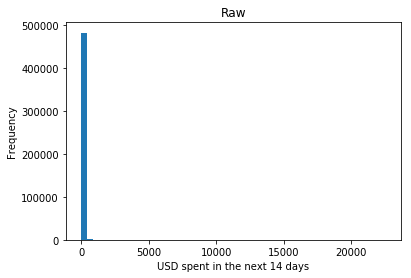

In [18]:
plt.hist(spend_usd_next_14_days, bins=50)
plt.xlabel("USD spent in the next 14 days")
plt.ylabel("Frequency")
plt.title("Raw")
plt.show()

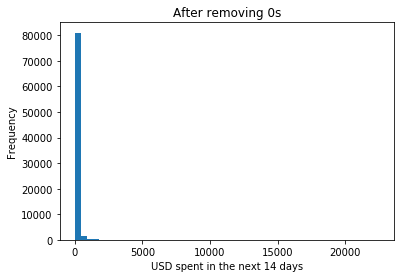

In [19]:
plt.hist(spend_usd_next_14_days[spend_usd_next_14_days!=0], bins=50)
plt.xlabel("USD spent in the next 14 days")
plt.ylabel("Frequency")
plt.title("After removing 0s")
plt.show()

In [23]:
n = len(spend_usd_next_14_days)
print 'percentage users spending more than 100 USD: ', len(spend_usd_next_14_days[spend_usd_next_14_days>=100])/float(n)
print 'percentage spending more than 500 USD: ', len(spend_usd_next_14_days[spend_usd_next_14_days>=500])/float(n)

percentage users spending more than 100 USD:  0.027572637538
percentage spending more than 500 USD:  0.00374930061917


The distribution is highly skewed because of the outliers - a few extremely large transactions. Only 2.7% of users spent more than 100 USD, therefore I set 100 USD as the threshold to filter the data points. The plot looks better after the observations higher than 100 USD were removed.   
Most of the spendings are between 0~40 USD, which is a reasonable amount to spend at App Store.

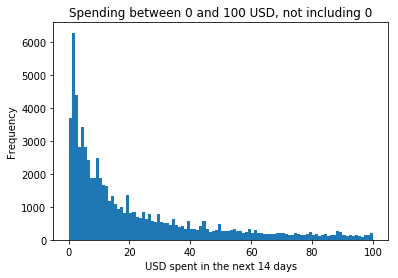

In [24]:
plt.hist(spend_usd_next_14_days[(spend_usd_next_14_days<=100) & (spend_usd_next_14_days!=0)], bins=100)
plt.xlabel("USD spent in the next 14 days")
plt.ylabel("Frequency")
plt.title("Spending between 0 and 100 USD, not including 0")
plt.show()

**Are users who made purchase before more likely to purchase in the future?**

In [26]:
pop_purchase_rate = np.mean(spend_usd_next_14_days!=0)
# if people had purchased before
purchased = df[df['made_purchase_before']==1]
purchased_purchase_rate = len(purchased[purchased['spend_usd_next_14_days']!=0]) / float(len(purchased))

print pop_purchase_rate*100, 'percent of users made purchases 14 days later'
print purchased_purchase_rate*100, 'percent of users who made purchases before made purchases 14 days later' 

17.169154156954477 percent of users made purchases 14 days later
73.0990766453 percent of users who made purchases before made purchases 14 days later


### Employ Purchase Funnel

**Customer journey towards the purchase of a product: **  
1) "Visited": entered the app store, saw the homepage and/or browsed products.  
2) "Cart": added interested product(s) to the shopping cart.  
3) "Clicked": decided to buy the product(s) and clicked the "buy" button to proceed to check out.  
4) "Purchased": provided the payment information and selected the prefered form of payment, and completed the purchase. 

Calculate the number of users at each stage  
Calculate the conversion rate at each stage: divide the number of users at each stage by population size  
Draw a plot to visualize the funnel

Number of users and conversion rates at each stage: 
      action       num cr_stage  conversion_rate
0    visited  484357.0      NaN         0.854699
1       cart  451933.0      NaN         0.797483
2    clicked  124233.0      NaN         0.219222
3  purchased  101911.0      NaN         0.179833


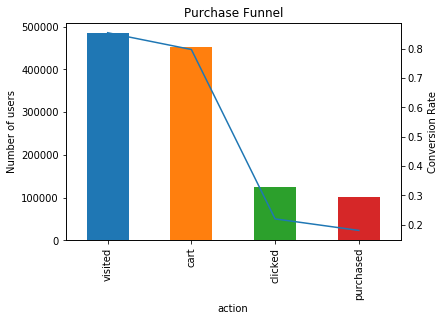

In [76]:
# number of users at each stage
n_total = len(my_data)
n_visited = len(df)
n_cart = df['saw_cart_before'].sum()
n_clicked = df['clicked_buy_before'].sum()
n_purchased = df['made_purchase_before'].sum()

# create dataframe the funnel model 
funnel_df = pd.DataFrame(columns=['action','num','cr_stage'])
funnel_df['action'] = ['visited','cart','clicked','purchased']
funnel_df['num'] = [n_visited, n_cart, n_clicked, n_purchased]
funnel_df['conversion_rate'] = np.array([n_visited, n_cart, n_clicked, n_purchased]) / n_total

print 'Number of users and conversion rates at each stage: '
print funnel_df

# visualize
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()
funnel_df.plot.bar('action','num', ax = ax1, legend=False)
funnel_df.plot('action','conversion_rate', ax = ax2, legend=False)
ax1.set_ylabel('Number of users')
ax2.set_ylabel('Conversion Rate')
ax1.set_title('Purchase Funnel')
plt.show()

      stage_to_stage  cr_from_to
0            visited    0.854699
1       visited_cart    0.933058
2       cart_clicked    0.274893
3  clicked_purchased    0.820321


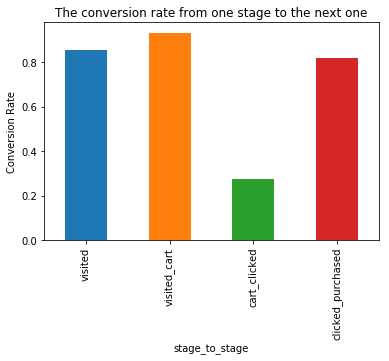

In [36]:
funnel_df['stage_to_stage'] = ['visited','visited_cart','cart_clicked','clicked_purchased']
funnel_df['cr_from_to'] = [n_visited/float(n_total), n_cart/n_visited, n_clicked/n_cart, n_purchased/n_clicked]
print funnel_df[['stage_to_stage','cr_from_to']]

funnel_df.plot.bar('stage_to_stage', 'cr_from_to', legend=False)
plt.ylabel('Conversion Rate')
plt.title("The conversion rate from one stage to the next one")
plt.show()

### Form of Payment

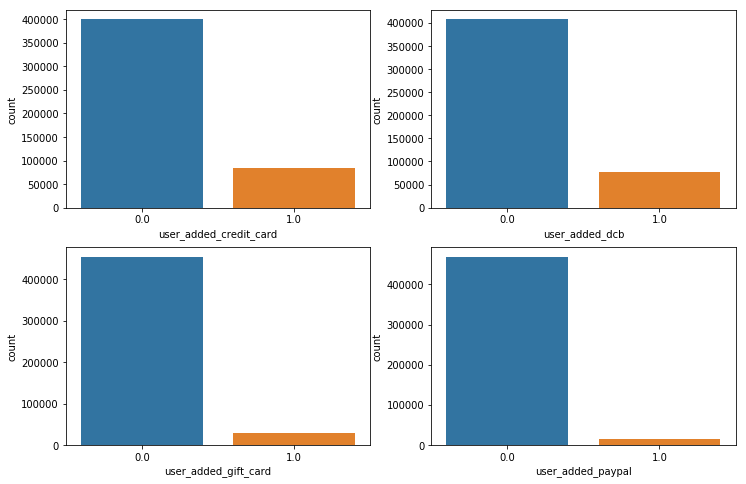

In [39]:
# check distribution
target_features = ['user_added_credit_card','user_added_dcb',
                   'user_added_gift_card','user_added_paypal']
# categorical variables histogram
fig = plt.figure(figsize=(12,8))
for i,column in enumerate(target_features):
    fig.add_subplot(2,2,i+1)
    sns.countplot(df[column])

Most people added credit card and dcb as their payment methods. Less people used gift card or paypal as their payment methods. 

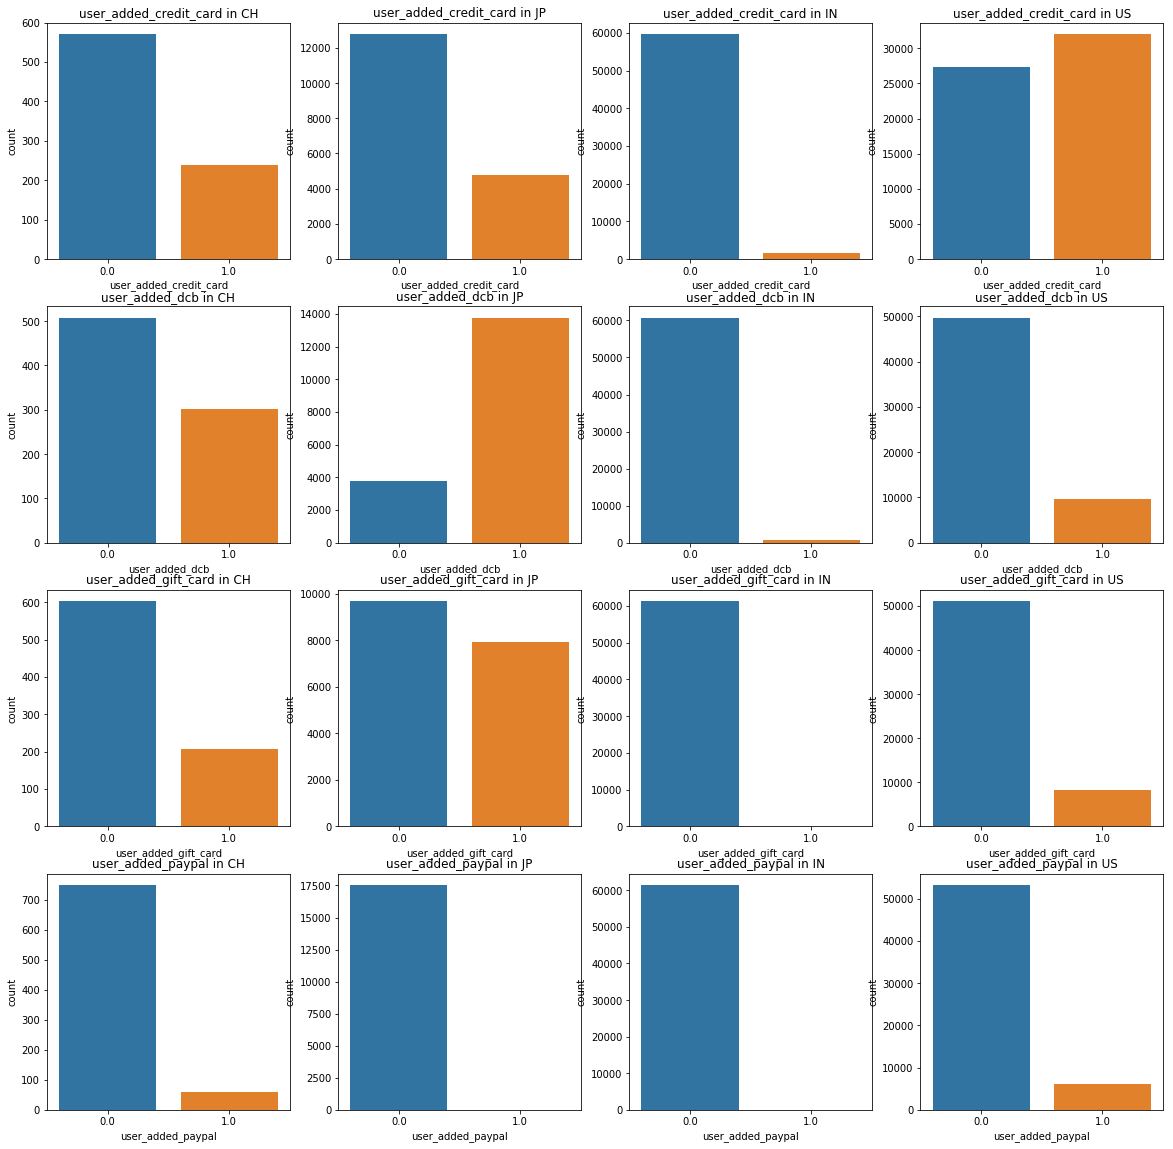

In [42]:
country = ['CH','JP','IN','US']
count = 1
fig = plt.figure(figsize=(20,20))
for i,fop in enumerate(target_features):
    for j,c in enumerate(country):
        fig.add_subplot(4,4,count)
        sns.countplot(df[df['country']==c][fop])
        plt.title(fop + ' in ' + c)
        count += 1

I decided to analyze the effect of payment method, therefore I focused on the stage between "clicked" and "purchased".  The idea was to check whether certain type of payment method led to higher conversion rate.

The conversion rate  in this setting:
$$ConversionRate = \frac{number \ of \ users \ w/ \ (clicked\_buy\_before = 1)}{number \ of \ users \ w/ \ (made\_purchased\_before = 1)}$$

However, some users have more than one payment methods, which means that we may not know which form of payment was used for the transaction. Thus, I proceed my analysis with two approaches:
* Ignore, study the users with multiple/single payment methods together
* Filter out the users w/ multiple payment method, study the users w/ only one payment method

In [49]:
def cr_fop(stages_from_to, fop, df):
    """
    stages_from_to: a list containing the starting and ending stage
    """
    # calculate the number of users at each stage for the type of payment method
    tmp = df[df[fop]==1][stages_from_to].sum()
    return tmp[1] / tmp[0]

stages_from_to = ['clicked_buy_before','made_purchase_before']

# conversion rate I
multiple_fop = []
for fop in target_features:
    cr = cr_fop(stages_from_to, fop, df)
    multiple_fop.append(cr)

# conversion rate II
df['num_of_fop'] = df['user_added_credit_card']+df['user_added_dcb']+ \
                       df['user_added_gift_card']+df['user_added_paypal']

single_fop_df = df[df['num_of_fop']==1] # filter out the users with multiple fop
single_fop = []
for fop in target_features:
    cr = cr_fop(stages_from_to, fop, single_fop_df)
    single_fop.append(cr)

print 'The number of users w/ fops', len(df)
print 'TThe number of users w/ single fop', len(single_fop_df)

The number of users w/ fops 484357
TThe number of users w/ single fop 113094


In [48]:
# distribution 
single_fop_df[target_features].sum() 

user_added_credit_card    51320.0
user_added_dcb            47251.0
user_added_gift_card       9326.0
user_added_paypal          5197.0
dtype: float64

FOP conversion rate: 
                      fop   >=1 fop  single_fop
0  user_added_credit_card  0.863623    0.809564
1          user_added_dcb  0.814635    0.711575
2    user_added_gift_card  0.960136    0.953946
3       user_added_paypal  0.883465    0.784256


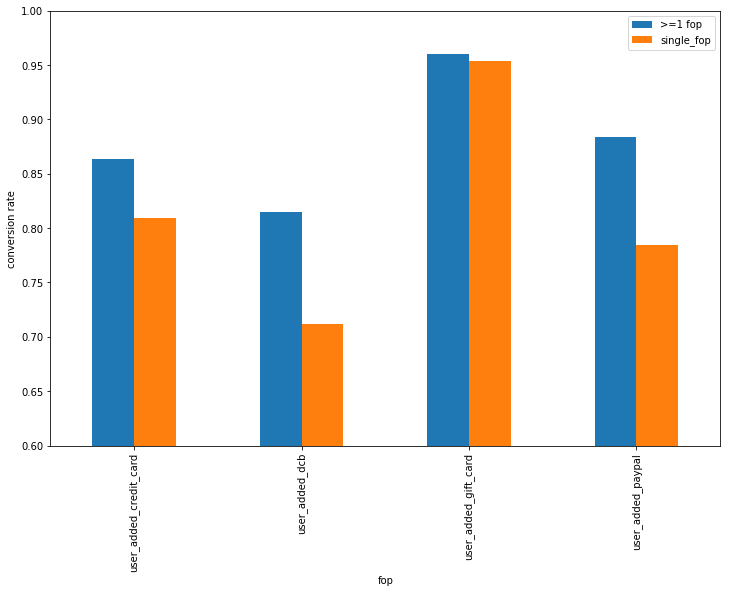

In [50]:
# visualize
res_fop_df = pd.DataFrame(columns=['fop','>=1 fop','single_fop'])
res_fop_df['fop'] = target_features
res_fop_df['>=1 fop'] = multiple_fop
res_fop_df['single_fop'] = single_fop
print 'FOP conversion rate: '
print res_fop_df
res_fop_df.plot.bar(x='fop',y=['>=1 fops','single_fop'],figsize=(12,8))
plt.ylim(0.6,1.0)
plt.ylabel("conversion rate")
plt.show()

## Set Up Experiment

From the exploratory analysis:
* More than 40% users only have dcb payment on file, but the conversion rate of this fop is low
* Gift card payment has the highest conversion rate 
* Comparing users with only one payment method, Credit Card has higher conversion rate than Paypal

Several possible strategies. 
* Ask more from good: raise credit card discount from 3% to 3.5%, encourageing users to use credit cards
* Fix things: create campaigns targeting the users who only use Paypal, encourageing them to use credit cards for payments

I A/B tested the second strategy - "Fix things". 49166 users were involved in the experiment, with 24695 users in the treatment group and 24471 users in the control group. 

## A/B test

In [52]:
experiment = pd.read_csv("experiment_result.csv")
experiment.head()

,country,date,experiment_id,order_id,spend_usd,user_bucket,user_id,vertical
0,NaN,NaN,12624549,NaN,0.0,3,1.655440e+19,NaN
1,NaN,NaN,12624548,NaN,0.0,14,1.441150e+19,NaN
2,NaN,NaN,12624549,NaN,0.0,20,8.425200e+18,NaN
3,NaN,NaN,12624549,NaN,0.0,16,1.130270e+19,NaN
4,NaN,NaN,12624549,NaN,0.0,14,1.399240e+18,NaN


In [55]:
experiment.shape

(49166, 8)

In [58]:
control = experiment[experiment['experiment_id']==12624549]['spend_usd']
treatment = experiment[experiment['experiment_id']==12624548]['spend_usd']

print 'Sample size:', len(experiment)
print 'Number of users in the treatment group: ', len(treatment)
print 'Number of users in the control group: ', len(control)

Sample size: 49166
Number of users in the treatment group:  24695
Number of users in the control group:  24471


In [64]:
print 'Treatment Group Stats:'
print treatment.describe(), '\n'
print 'Control Group Stats:'
print control.describe()

Treatment Group Stats:
count    24695.000000
mean         3.101232
std         11.647487
min          0.000000
25%          0.000000
50%          0.000000
75%          0.975661
max        119.990000
Name: spend_usd, dtype: float64 

Control Group Stats:
count    24471.000000
mean         2.807225
std         10.974284
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        199.990000
Name: spend_usd, dtype: float64


**two sample t-test; one sided test, with significance level = 0.05**  
miu_t = group mean of treatment group revenue  
miu_c = group mean of control group revenue

**Hypothesis:**  
**H0: miu_t <= miu_c** vs. **Ha: miu_t > miu_c**

In [72]:
from scipy import stats
results = stats.ttest_ind(treatment, control, equal_var=True)
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print 't-statistics =', results[0], ', p-value =', results[1],"\nReject null hypothesis, mean of {} is greater than mean of {}".format('treatment','control')
else:
    print "fail to reject null hypothesis"

t-statistics = 2.8801076680362367 , p-value = 0.003977110569393284 
Reject null hypothesis, mean of treatment is greater than mean of control


Since the p-value/2 is smaller than 0.05 (one-sided), and the t-statistics is greater than 0, I rejected the null hypothesis at a 5% level of significance, and concluded that treatment group has larger revenue.  
**Hence, my action policy will increase the revenue of the App Store.** I recommend the company to focus more on the users who only use Paypal as the payment method, and customize targeted campaign strategies to encourage users to use credit cards.

To back my recommendation, I calculated the expectated amount of increase in revenue:

In [74]:
(treatment.mean() - control.mean()) / control.mean()

0.10473244392420508